

```
# Ce texte est au format code
```

# Importation des bibliotheques necessaires pour le projet

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive


drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Projet SDD/base_fusion_filtered.csv'
data = pd.read_csv(file_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Nettoayge des données

In [ ]:
import pandas as pd

#Apres la recupération de deux bases, une sur les données climatiques et l'autre les impacts environnementaux
# On va procéder a la fusion de sorte à recupérer un fichier exploitable pour l'analyse du projet
climate_data_path = 'climate_change_data.csv'
impact_data_path = 'impact.xlsx'

climate_data = pd.read_csv(climate_data_path)
impact_data = pd.read_excel(impact_data_path)

# Étape 1 : Préparer les données climatiques
# Convertir la colonne 'Date' en type datetime et extraire l'année
climate_data['Date'] = pd.to_datetime(climate_data['Date'], errors='coerce')
climate_data['Year'] = climate_data['Date'].dt.year

#Nous avons voulu nous concentrer uniquement sur les années allant de 2016 à 2022
climate_data = climate_data[climate_data['Year'] >= 2016]

# L'intérêt étant de traiter les données par année et par pays
climate_aggregated = climate_data.groupby(['Year', 'Country']).agg({
    'Temperature': 'mean',
    'CO2 Emissions': 'mean',
    'Sea Level Rise': 'mean',
    'Precipitation': 'mean',
    'Humidity': 'mean',
    'Wind Speed': 'mean'
}).reset_index()

# Étape 2 : Préparer les données d'impact
# Convertir la colonne 'Year' en type numérique et filtrer les données de 2016 et après
impact_data['Year'] = pd.to_numeric(impact_data['Year'], errors='coerce')
impact_data = impact_data[impact_data['Year'] >= 2016]

# S'assurer que les colonnes numériques sont bien formatées
numeric_columns = ['Total Events', 'Total Affected', 'Total Deaths',
                   'Total Damage (USD, original)', 'Total Damage (USD, adjusted)']
for col in numeric_columns:
    impact_data[col] = pd.to_numeric(impact_data[col], errors='coerce')


# Étape 3 : Fusionner les deux bases de données
merged_data = pd.merge(climate_aggregated, impact_data, on=['Year', 'Country'], how='inner')

# Sauvegarde des données pour l'utilisation finale
merged_data.to_csv('base_fusion_filtered.csv', index=False)

print("Les données ont été fusionnées avec succès et enregistrées sous 'base_fusion_filtered.csv'.")


# Partie Numpy composantes ACP


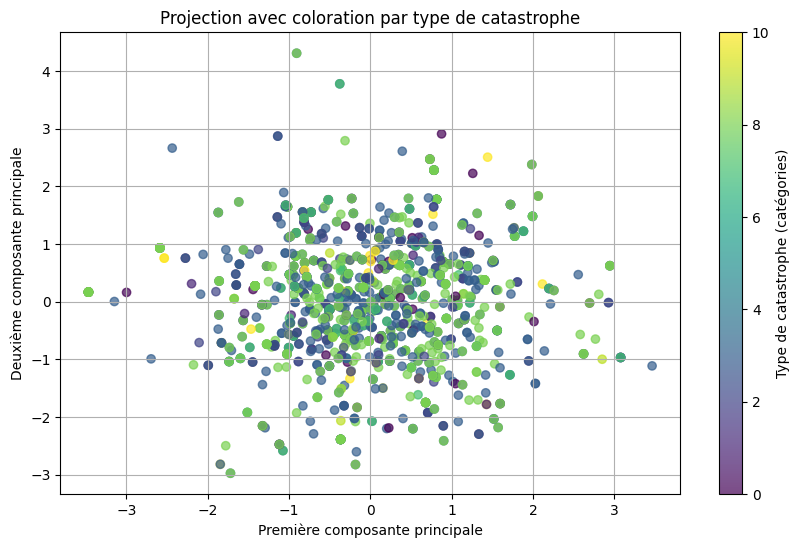

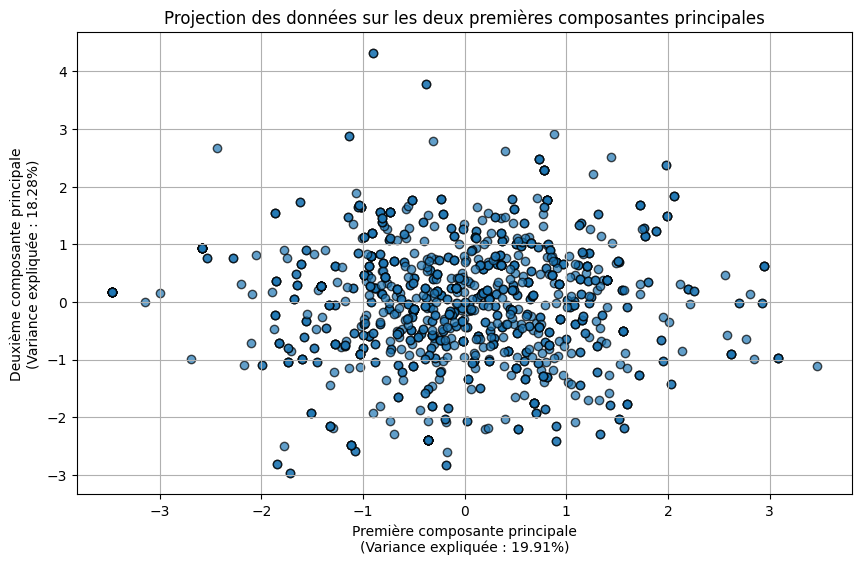

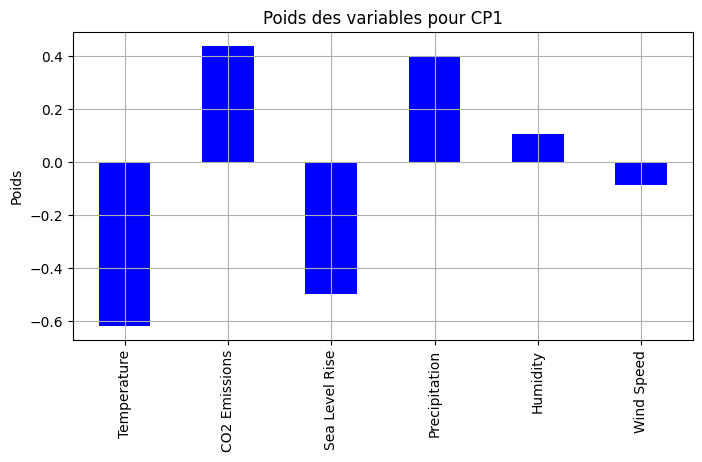

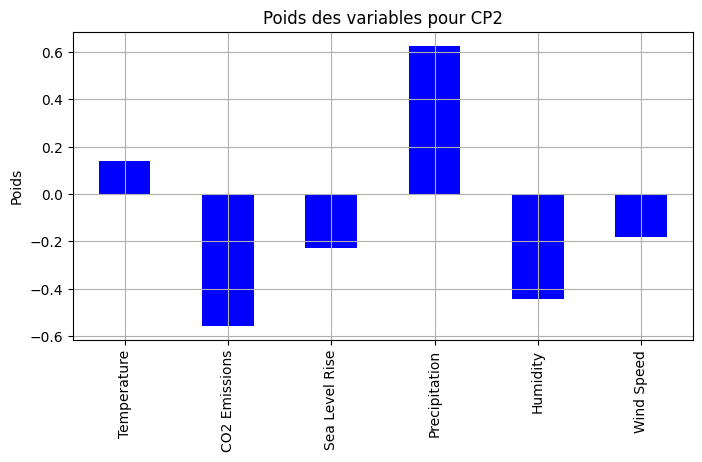

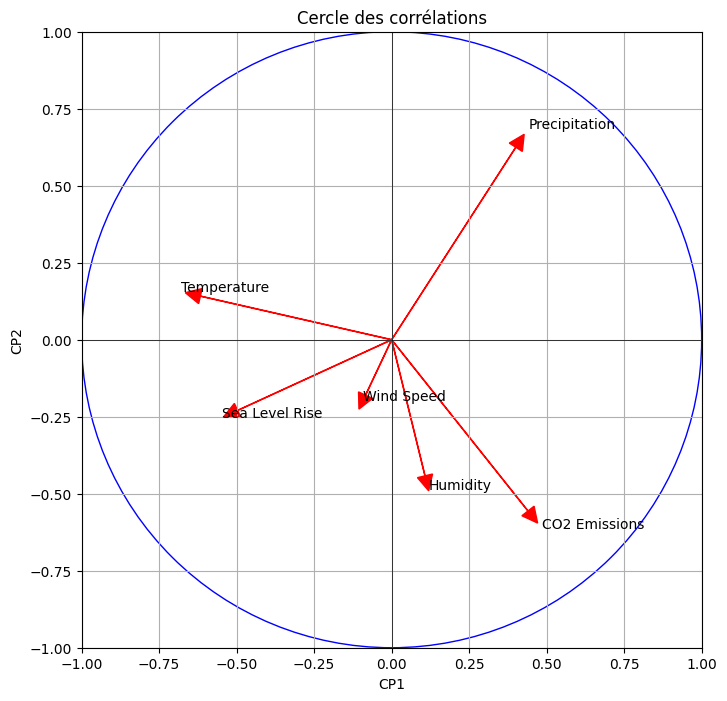

In [ ]:
# Étape 1 : Sélectionner les données pertinentes
columns_pour_acp = ['Temperature', 'CO2 Emissions', 'Sea Level Rise', 'Precipitation', 'Humidity', 'Wind Speed']
data_acp = data[columns_pour_acp]

# Étape 2 : Normaliser les données
normalisation = (data_acp - data_acp.mean()) / data_acp.std()

# Étape 3 : Calculer la matrice de covariance
matrice_cov = np.cov(normalisation.T)

# Étape 4 : Calculer les valeurs propres et vecteurs propres
v_propres, vecteurs_propres = np.linalg.eig(matrice_cov)

# Étape 5 : Trier les valeurs propres et sélectionner les principales
indice_trie = np.argsort(v_propres)[::-1]
valeurs_p_trie = v_propres[indice_trie]
vecteurs_p_trie = vecteurs_propres[:, indice_trie]


# Étape 6 : Projeter les données dans l'espace des composantes principales
projection_matrice = vecteurs_p_trie[:, :2]  # Prendre les deux premières composantes principales
projected_data = normalisation @ projection_matrice

# Ajouter une couleur selon le type de catastrophe
colors = data['Disaster Type'].astype('category').cat.codes
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    projected_data.iloc[:, 0],
    projected_data.iloc[:, 1],
    c=colors,
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label='Type de catastrophe (catégories)')
plt.title("Projection avec coloration par type de catastrophe")
plt.xlabel("Première composante principale")
plt.ylabel("Deuxième composante principale")
plt.grid()
plt.show()


explained_variance_ratio = valeurs_p_trie / np.sum(valeurs_p_trie)

 #Étape 7 : Visaualisaiton: plusieurs graphe possible, a voir lequel choisir
plt.figure(figsize=(10, 6))
plt.scatter(projected_data.iloc[:, 0], projected_data.iloc[:, 1], alpha=0.7, edgecolor='k')
plt.title("Projection des données sur les deux premières composantes principales")
plt.xlabel(f"Première composante principale\n(Variance expliquée : {explained_variance_ratio[0] * 100:.2f}%)")
plt.ylabel(f"Deuxième composante principale\n(Variance expliquée : {explained_variance_ratio[1] * 100:.2f}%)")
plt.grid()
plt.show()


# Étape 8 : Création du DataFrame pour les poids des variables
poids_variables = pd.DataFrame(vecteurs_p_trie, index=columns_pour_acp, columns=[f"CP{i+1}" for i in range(len(valeurs_p_trie))])

# Graphique pour CP1
plt.figure(figsize=(8, 4))
poids_variables["CP1"].plot(kind='bar', title="Poids des variables pour CP1", color='blue')
plt.ylabel("Poids")
plt.grid()
plt.show()

# Graphique pour CP2
plt.figure(figsize=(8, 4))
poids_variables["CP2"].plot(kind='bar', title="Poids des variables pour CP2", color='blue')
plt.ylabel("Poids")
plt.grid()
plt.show()


# Étape 9 : Création du cercle des corrélations
plt.figure(figsize=(8, 8))
for i in range(len(columns_pour_acp)):
    plt.arrow(0, 0, vecteurs_p_trie[i, 0], vecteurs_p_trie[i, 1],
              head_width=0.05, head_length=0.05, fc='red', ec='red')
    plt.text(vecteurs_p_trie[i, 0] * 1.1, vecteurs_p_trie[i, 1] * 1.1,
             columns_pour_acp[i], color='black')

circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()
plt.title("Cercle des corrélations")
plt.xlabel("CP1")
plt.ylabel("CP2")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [ ]:
#code pour le cercle de correlation:

#Blox-plot (Sécheresses,Mass movement) /(humidité)

Année 2016 : 19 lignes après filtrage.


<ipython-input-2-e4ba1e73c359>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


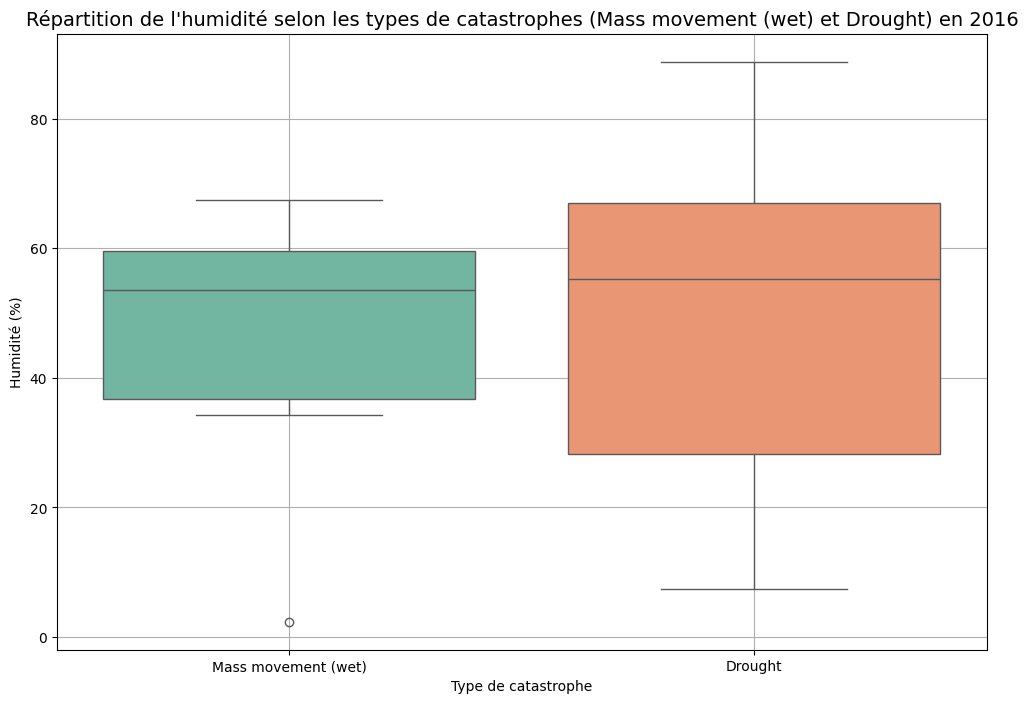

Année 2017 : 22 lignes après filtrage.


<ipython-input-2-e4ba1e73c359>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


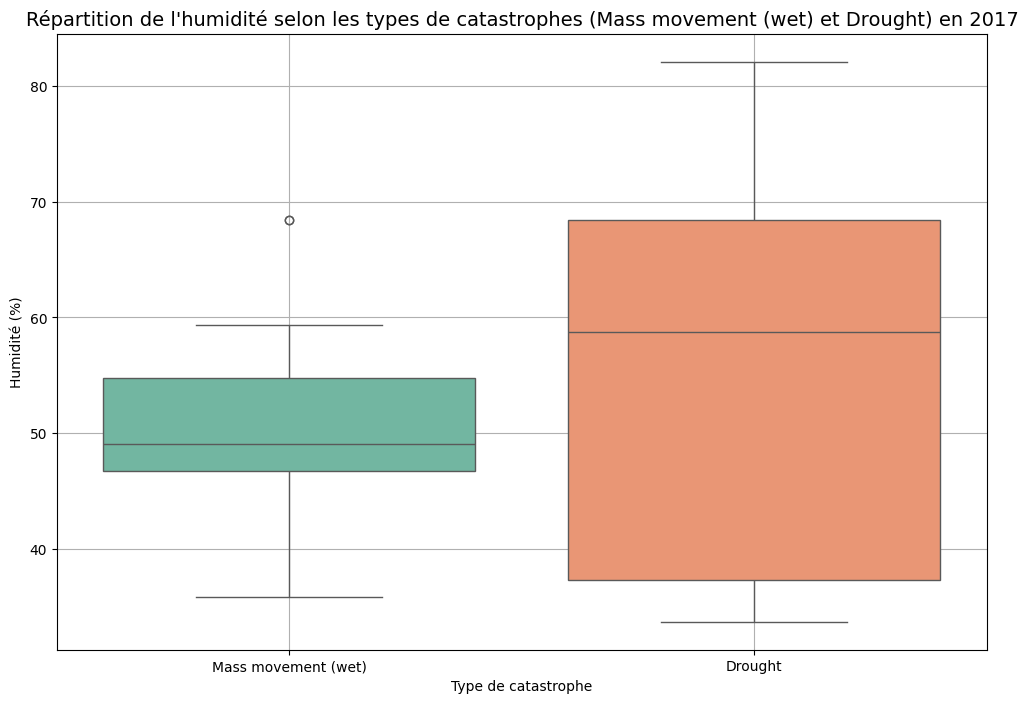

Année 2018 : 22 lignes après filtrage.


<ipython-input-2-e4ba1e73c359>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


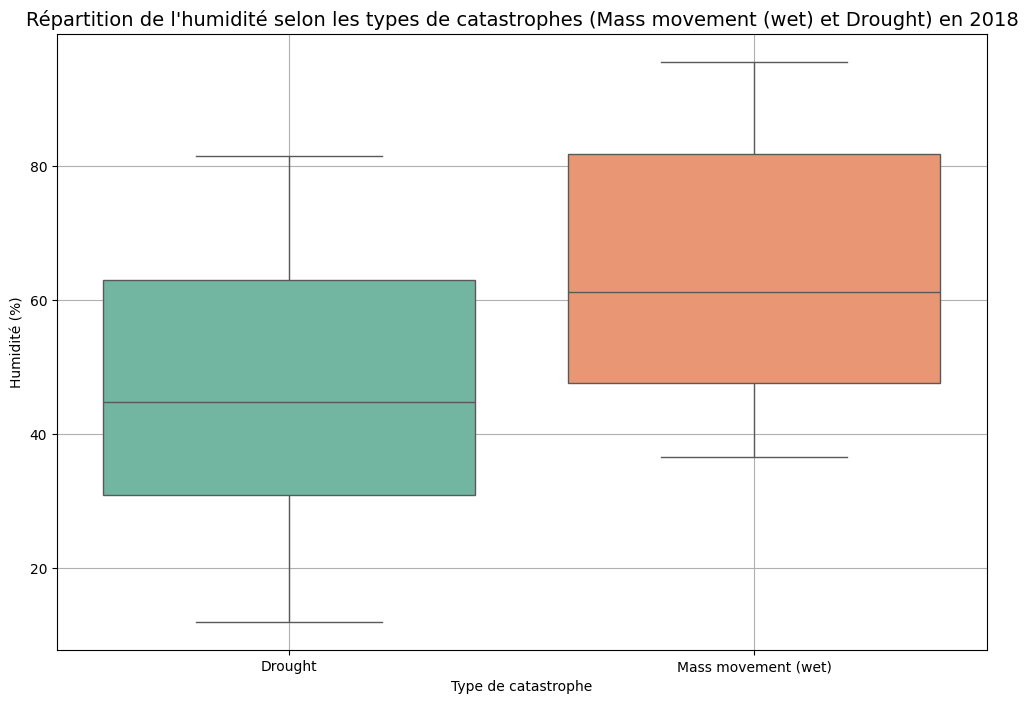

Année 2019 : 24 lignes après filtrage.


<ipython-input-2-e4ba1e73c359>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


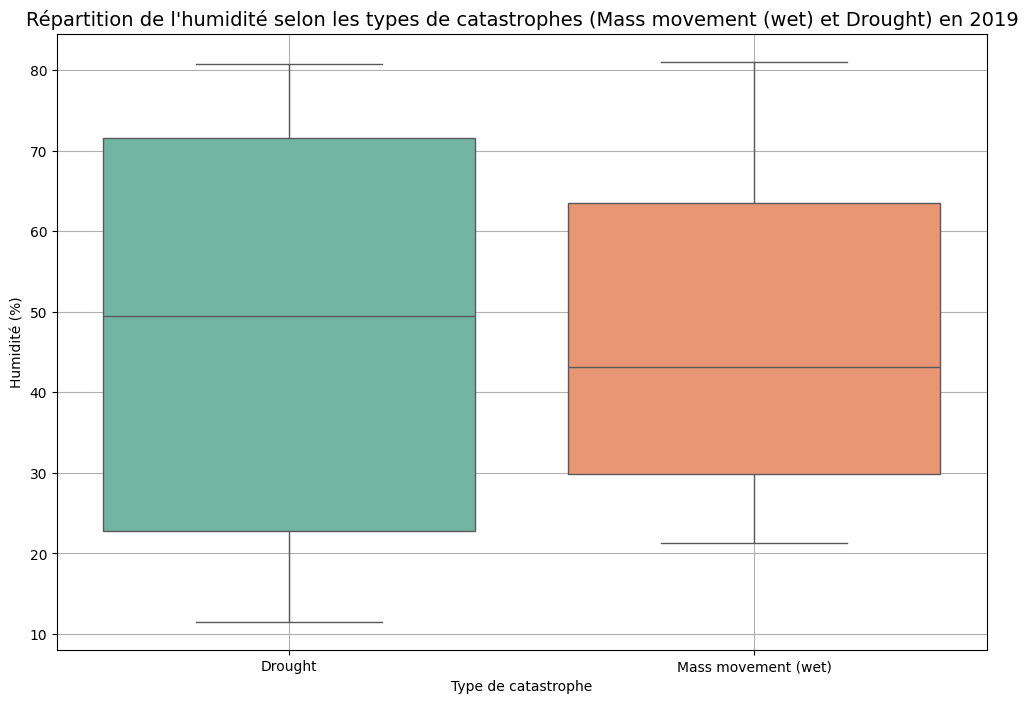

In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
file_path = '/base_fusion_filtered.csv'
data = pd.read_csv(file_path)

# Définir les colonnes
year_col = 'Year'
disaster_col = 'Disaster Type'
humidity_col = 'Humidity'
country_col = 'Country'

# Vérifier que les colonnes nécessaires sont présentes
if all(col in data.columns for col in [year_col, disaster_col, humidity_col, country_col]):
    # Étape 1 : Définir les années à analyser
    years_to_analyze = [2016, 2017, 2018, 2019]
    disaster_types = ['Mass movement (wet)', 'Drought']  # Types de catastrophes à analyser

    for year in years_to_analyze:
        # Filtrer les données pour une année donnée
        data_year = data[data[year_col] == year]

        # Filtrer pour les types de catastrophes spécifiques
        disaster_data = data_year[data_year[disaster_col].isin(disaster_types)]

        # Supprimer les lignes avec des valeurs manquantes pour l'humidité
        disaster_data = disaster_data.dropna(subset=[humidity_col])

        # Vérification des données filtrées
        print(f"Année {year} : {disaster_data.shape[0]} lignes après filtrage.")
        if disaster_data.empty:
            print(f"Aucune donnée disponible pour l'année {year}.")
            continue

        # Étape 2 : Visualisation pour l'année en cours
        plt.figure(figsize=(12, 8))
        sns.boxplot(
            data=disaster_data,
            x=disaster_col,
            y=humidity_col,
            palette='Set2'
        )

        # Ajouter des titres et légendes
        plt.title(f"Répartition de l'humidité selon les types de catastrophes (Mass movement (wet) et Drought) en {year}", fontsize=14)
        plt.xlabel("Type de catastrophe")
        plt.ylabel("Humidité (%)")
        plt.grid(True)
        plt.show()
else:
    print("Certaines colonnes nécessaires sont manquantes dans les données.")


#Les box-plots montrent la répartition des taux d'humidité associés aux glissements de terrain et aux sécheresses entre 2016 et 2019.
En comparant 2016 et 2017, les sécheresses de 2017 montrent une humidité médiane plus basse (40 % contre 50 % en 2016), indiquant des conditions plus sèches, tandis que les glissements de terrain de 2017 se produisent dans des conditions plus homogènes

Nous avons réalisé quatre box-plots qui montrent la répartition des taux d'humidité associés à deux types de catastrophes naturelles, Mass movement (wet) et Drought, pour les années 2016, 2017, 2018 et 2019.

Étudions année par année ces box-plots.
L’année 2016 montre que les glissements de terrain liés à des précipitations abondantes nécessitent généralement des niveaux d'humidité élevés. Ici 50 % des valeurs se trouvent entre 40 et 60 % d’humidité. On peut en déduire que les conditions climatiques étaient variables cette année là.
Pour la sécheresse on peut observer que les valeurs sont dispersées dans le quartile inférieur car la médiane est autour des 60 % d’humidité.

L’année 2017 montre que les glissements de terrain ont une répartition beaucoup plus serrée que l’année précédente. Cela montre que les événements de glissement  se sont produits dans des conditions homogènes, avec une humidité modérée.
On peut observer que les niveaux d’humidité associés aux sécheresses sont globalement les mêmes, on peut donc en déduire des épisodes de sécheresse équivalent en 2017 avec une médiane autour de 60%.

En 2018, les sécheresses semblent s’être produites dans des conditions un peu plus humides par rapport à 2017, bien que des valeurs basses (23 %) indiquent encore des périodes très sèches.
Les conditions pour les glissements de terrain semblent un peu plus sèches en 2018, avec une médiane légèrement inférieure à celle des années précédentes. Cela pourrait indiquer des glissements de terrain déclenchés par des précipitations soudaines.

En 2019, la sécheresse est assez similaire aux sécheresses de 2018. Les glissements de terrains montrent des conditions d’humidité cohérentes par rapport à 2018. Cela pourrait indiquer une certaine stabilité des conditions climatiques responsables de ces événements.

Les glissements de terrain montrent une stabilisation des conditions climatiques après 2016, avec des taux d'humidité modérés et homogènes (40–60 % en médiane). Cela reflète peut-être une régularité dans les précipitations nécessaires à ces événements.
Les sécheresses restent associées à une humidité faible, mais les années 2018 et 2019 reflètent peut-être un climat légèrement plus humide ou des événements moins sévères qu'en 2017.

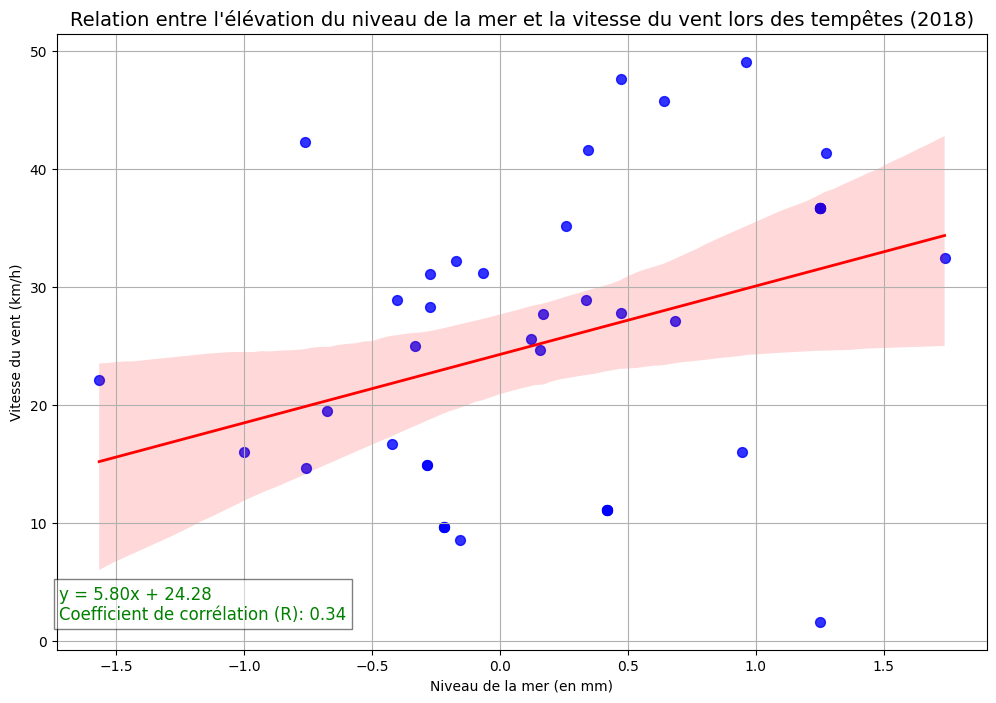

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

year_col = 'Year'
disaster_col = 'Disaster Type'
sea_level_rise_col = 'Sea Level Rise'
wind_speed_col = 'Wind Speed'
country_col = 'Country'


data = pd.read_csv('base_fusion_filtered.csv')

if all(col in data.columns for col in [year_col, disaster_col, sea_level_rise_col, wind_speed_col, country_col]):
    disaster_type = 'Storm'
    data_2018 = data[data[year_col] == 2018]

    storm_data = data_2018[data_2018[disaster_col].str.contains(disaster_type, case=False, na=False)]

    if not storm_data.empty:
        slope, intercept, r_value, p_value, std_err = linregress(
            storm_data[sea_level_rise_col],
            storm_data[wind_speed_col]
        )
        regression_eq = f"y = {slope:.2f}x + {intercept:.2f}"

        correlation_coefficient = r_value

        plt.figure(figsize=(12, 8))
        sns.regplot(
            data=storm_data,
            x=sea_level_rise_col,  # Élévation du niveau de la mer sur l'axe des X
            y=wind_speed_col,  # Vitesse du vent sur l'axe des Y
            scatter_kws={'color': 'blue', 's': 50},  # Style des points
            line_kws={'color': 'red', 'lw': 2},  # Style de la ligne de régression
        )

        plt.title("Relation entre l'élévation du niveau de la mer et la vitesse du vent lors des tempêtes (2018)", fontsize=14)
        plt.xlabel("Niveau de la mer (en mm)")
        plt.ylabel("Vitesse du vent (km/h)")
        plt.grid(True)

        plt.text(
            x=storm_data[sea_level_rise_col].min() * 1.1,
            y=storm_data[wind_speed_col].min() * 1.1,
            s=f"{regression_eq}\nCoefficient de corrélation (R): {correlation_coefficient:.2f}",
            fontsize=12,
            color="green",
            bbox=dict(facecolor='white', alpha=0.5)
        )

        plt.show()
    else:
        print("Aucune donnée disponible pour les tempêtes en 2018.")

else:
    print("Certaines colonnes nécessaires sont manquantes dans les données.")


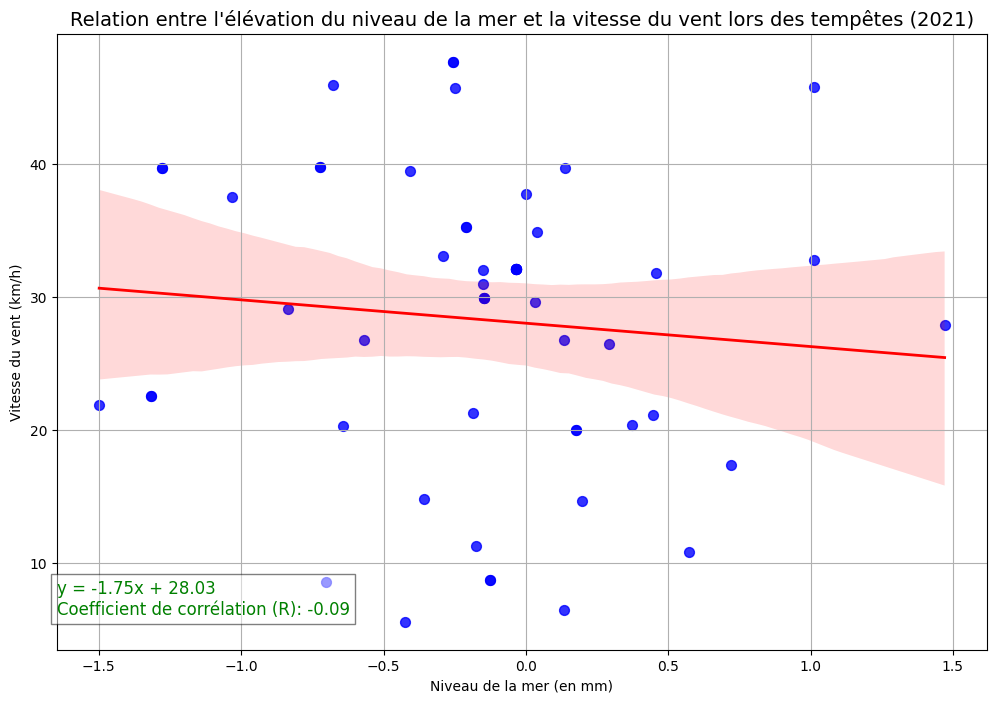

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

year_col = 'Year'
disaster_col = 'Disaster Type'
sea_level_rise_col = 'Sea Level Rise'
wind_speed_col = 'Wind Speed'
country_col = 'Country'


data = pd.read_csv('base_fusion_filtered.csv')

if all(col in data.columns for col in [year_col, disaster_col, sea_level_rise_col, wind_speed_col, country_col]):
    disaster_type = 'Storm'
    data_2021 = data[data[year_col] == 2021]

    storm_data = data_2021[data_2021[disaster_col].str.contains(disaster_type, case=False, na=False)]

    if not storm_data.empty:
        slope, intercept, r_value, p_value, std_err = linregress(
            storm_data[sea_level_rise_col],
            storm_data[wind_speed_col]
        )
        regression_eq = f"y = {slope:.2f}x + {intercept:.2f}"

        correlation_coefficient = r_value

        plt.figure(figsize=(12, 8))
        sns.regplot(
            data=storm_data,
            x=sea_level_rise_col,
            y=wind_speed_col,
            scatter_kws={'color': 'blue', 's': 50},
            line_kws={'color': 'red', 'lw': 2},
        )

        plt.title("Relation entre l'élévation du niveau de la mer et la vitesse du vent lors des tempêtes (2021)", fontsize=14)
        plt.xlabel("Niveau de la mer (en mm)")
        plt.ylabel("Vitesse du vent (km/h)")
        plt.grid(True)

        plt.text(
            x=storm_data[sea_level_rise_col].min() * 1.1,
            y=storm_data[wind_speed_col].min() * 1.1,
            s=f"{regression_eq}\nCoefficient de corrélation (R): {correlation_coefficient:.2f}",
            fontsize=12,
            color="green",
            bbox=dict(facecolor='white', alpha=0.5)
        )

        plt.show()
    else:
        print("Aucune donnée disponible pour les tempêtes en 2018.")

else:
    print("Certaines colonnes nécessaires sont manquantes dans les données.")


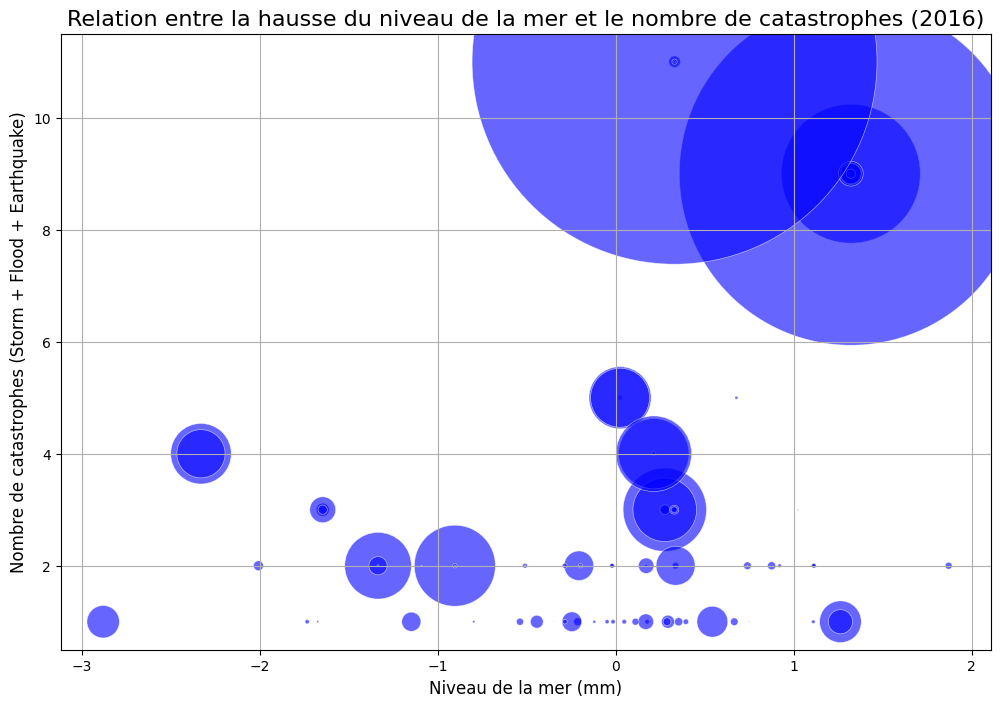

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('base_fusion_filtered.csv')

# Étape 2 : Calculer le nombre de catastrophes de type Storm, Flood et Earthquake
def calculate_disasters(file_name):
    data = pd.read_csv(file_name)

    data_2016 = data[data['Year'] == 2016]

    disaster_types = ['Storm', 'Flood', 'Earthquake']
    disaster_data = data_2016[data_2016['Disaster Type'].isin(disaster_types)]

    disaster_count = disaster_data.groupby('Country')['Disaster Type'].count().reset_index()
    disaster_count.columns = ['Country', 'Total Disasters']

    sea_level_data = data_2016[['Country', 'Sea Level Rise', 'Total Affected']].drop_duplicates()
    merged_data = pd.merge(disaster_count, sea_level_data, on='Country', how='inner')

    return merged_data

# Étape 3 : Créer un diagramme à bulles
def plot_bubble_chart(file_name):
    merged_data = calculate_disasters(file_name)

    plt.figure(figsize=(12, 8))
    plt.scatter(merged_data['Sea Level Rise'], merged_data['Total Disasters'],
                s=merged_data['Total Affected'] / 1000, alpha=0.6, color='blue', edgecolors="w", linewidth=0.5)

    plt.title('Relation entre la hausse du niveau de la mer et le nombre de catastrophes (2016)', fontsize=16)
    plt.xlabel('Niveau de la mer (mm)', fontsize=12)
    plt.ylabel('Nombre de catastrophes (Storm + Flood + Earthquake)', fontsize=12)
    plt.grid(True)
    plt.show()

plot_bubble_chart('base_fusion_filtered.csv')


#Graphique en 3D mettant en relation les incendies et les événements volcaniques avec l'émission de CO2

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

# Charger les données
file_path = '/content/base_fusion_filtered.csv'
data = pd.read_csv(file_path)

# Filtrage pour les types de catastrophes spécifiques
filtered_data = data[data["Disaster Type"].isin(["Wildfire", "Volcanic activity"])]

# Préparation des données
x = filtered_data["Year"]  # Années
y = filtered_data["CO2 Emissions"]  # Émissions de CO2
z = filtered_data["Disaster Type"]

# Taille des bulles proportionnelle au total des personnes affectées (gravité)
size = filtered_data["Total Affected"].fillna(0)
size = np.log1p(size) * 15  # Échelle ajustée pour des bulles plus grandes

# Création du graphique interactif avec palette inversée
fig = px.scatter_3d(
    filtered_data,
    x="Year",
    y="CO2 Emissions",
    z="Disaster Type",
    size=size,  # Taille des bulles
    color="CO2 Emissions",  # Couleur basée sur les émissions de CO2
    color_continuous_scale="RdBu_r",  # Bleu inversé vers rouge inversé
    title="Bulles 3D Interactives : Type de Catastrophes et Émissions de CO2",
    labels={"CO2 Emissions": "Émissions de CO2", "Year": "Année", "Disaster Type": "Événements"},
)

# Options de personnalisation : suppression de la grille
fig.update_layout(scene=dict(xaxis_showgrid=False, yaxis_showgrid=False, zaxis_showgrid=False))

# Afficher le graphique interactif
fig.show()


#Graphique à bulle 3D interactives mettant en valeur l'émission de CO2 lors de catastrophes naturelles tel que les incendies de forêt(Wildfire) et les activités volcaniques (Volcanic activity) au cours des années.

On a réalisé un graphique avec des bulles 3D interactives qui prend en compte 3 catégories.

1)L’émission de CO2 qui est sur le graphique l’axe X. Cela correspond à la quantité de CO2 en tonne émis par an. Certaines catastrophes naturelles, comme les incendies de forêt et les éruptions volcaniques, contribuent de manière significative à ces émissions.

 2)L’axe Y correspond à la fréquence des incendies de forêts ou superficie. Cet axe montre le nombre d’incendies ou la superficie totale brûlée au fil des années. Grâce à ces données, on peut savoir si les incendies entraînent une augmentation des émissions de CO2.

3)Enfin l’axe Z correspond à la fréquence des activités volcaniques. On sait que les incidents volcaniques libèrent énormément de CO2. Ces données vont nous permettre de confirmer cela.

Dans ce graphe, la taille des bulles représente l’ampleur de la catastrophe ; c’est à dire, plus la catastrophe est importante plus la bulle sera grande.
En analysant le graphe, on peut observer que les bulles avec des émissions de CO2 élevées sur l'axe X sont souvent associés à une fréquence ou une superficie importante des incendies de forêts (axe Y). Cela est visible par des bulles de grande taille situées dans la partie droite du graphique, indiquant que les périodes à fortes émissions de CO2 coïncident avec des incendies de grande ampleur. On peut également observer sur l’axe Z, la fréquence des activités volcaniques varie sans lien direct apparent avec les émissions de CO2.

En revanche, la fréquence des activités volcaniques (axe Z) ne montre pas de relation directe avec les émissions de CO2. Cependant, lorsqu'une activité volcanique est détectée, elle entraîne souvent une augmentation ponctuelle du CO2 libéré dans l’atmosphère, comme le montrent certaines bulles situées à des hauteurs élevées sur l’axe Z.

Le graphique met en évidence que les périodes à fortes émissions de CO2 sont principalement associées aux incendies de forêt. Les activités volcaniques, bien que moins fréquentes, contribuent également ponctuellement à l’impact environnemental global.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
data = pd.read_csv('base_fusion_filtered.csv')
print(data.head())

   Year    Country  Temperature  CO2 Emissions  Sea Level Rise  Precipitation  \
0  2016    Albania    15.150820     369.229590       -0.120683      44.886077   
1  2016  Argentina    13.166625     373.198811       -0.443364      23.349694   
2  2016    Armenia     9.354098     401.373527        0.773840      78.956807   
3  2016  Australia    16.166558     409.065777       -0.146357      69.410464   
4  2016  Australia    16.166558     409.065777       -0.146357      69.410464   

    Humidity  Wind Speed  ISO Disaster Group Disaster Subroup  \
0  62.479899   22.661700  ALB        Natural     Hydrological   
1  49.517723   23.714100  ARG        Natural     Hydrological   
2  59.536280    5.046787  ARM        Natural     Hydrological   
3  43.202413   21.489399  AUS        Natural   Climatological   
4  43.202413   21.489399  AUS        Natural     Hydrological   

         Disaster Type                  Disaster Subtype  Total Events  \
0                Flood                   Flood (

<ipython-input-4-10ed8c55f188>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


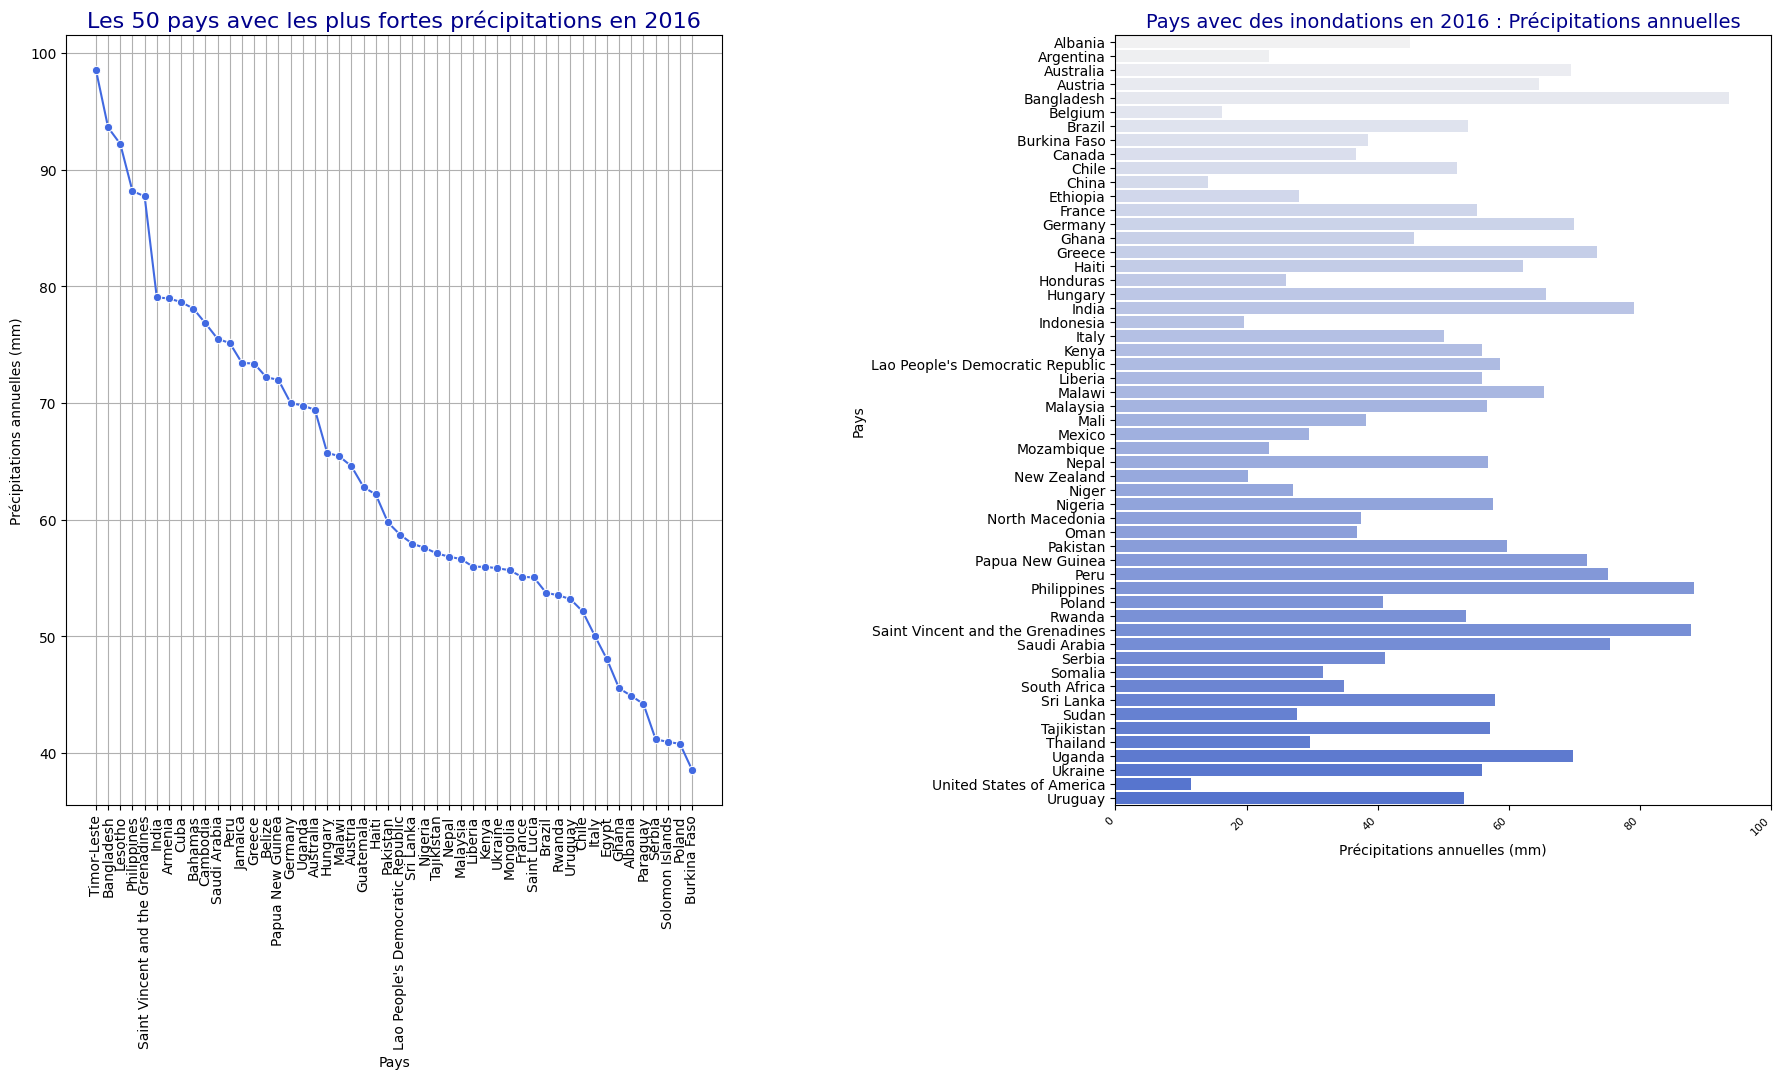

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Étape 1 : Filtrer les données pour l'année 2016
data_2016 = data[data['Year'] == 2016]

# Étape 2 : Filtrer les pays avec les plus fortes précipitations
precip_col = 'Precipitation'
country_col = 'Country'

# Vérifier que les colonnes nécessaires existent dans le dataframe
if precip_col in data_2016.columns and country_col in data_2016.columns:
    # Trier les pays par précipitations de manière décroissante
    top_precip_data = data_2016[[country_col, precip_col]].drop_duplicates().sort_values(by=precip_col, ascending=False)

    # Prendre les 50 premiers pays avec les plus fortes précipitations
    top_50_precip_data = top_precip_data.head(50)

    # Étape 3 : Filtrer pour les inondations (Flood) uniquement
    disaster_col = 'Disaster Type'  # Nom exact de la colonne pour les types de catastrophes

    if disaster_col in data_2016.columns and precip_col in data_2016.columns and country_col in data_2016.columns:
        # Filtrer les pays où la catastrophe est une inondation
        flood_data = data_2016[data_2016[disaster_col].str.contains('Flood', case=False, na=False)]

        # Conserver uniquement les pays et précipitations associés aux inondations
        flood_summary = flood_data[[country_col, precip_col, disaster_col]].drop_duplicates()

        # Créer une figure avec deux graphiques côte à côte
        fig, axes = plt.subplots(1, 2, figsize=(22, 10))  # Taille de la figure augmentée

        # Graphique 1 : Précipitations des 50 pays avec les plus fortes précipitations
        sns.lineplot(
            data=top_50_precip_data,  # Utiliser les 50 pays avec les précipitations les plus élevées
            x=country_col,  # Pays
            y=precip_col,   # Précipitations
            marker="o",  # Ajouter des marqueurs pour chaque pays
            color='royalblue',  # Couleur bleue claire pour la ligne
            ax=axes[0]  # Affecter ce graphique à la première sous-figure
        )
        axes[0].set_title("Les 50 pays avec les plus fortes précipitations en 2016", fontsize=16, color='darkblue')
        axes[0].set_xlabel("Pays")
        axes[0].set_ylabel("Précipitations annuelles (mm)")
        axes[0].tick_params(axis='x', rotation=90)  # Rotation des noms de pays pour plus de lisibilité
        axes[0].grid(True)

        # Graphique 2 : Précipitations pour les pays avec des inondations
        # Créer un dégradé de bleu clair à bleu foncé et extraire une palette de couleurs
        palette = sns.light_palette("royalblue", n_colors=len(flood_summary))

        sns.barplot(
            data=flood_summary,
            x='Precipitation',
            y=country_col,
            palette=palette,  # Utiliser la palette de couleurs générée
            ax=axes[1]  # Affecter ce graphique à la deuxième sous-figure
        )
        axes[1].set_title("Pays avec des inondations en 2016 : Précipitations annuelles", fontsize=14, color='darkblue')
        axes[1].set_xlabel("Précipitations annuelles (mm)")
        axes[1].set_ylabel("Pays")

        # Rotation et ajustement des labels de l'axe X
        plt.xticks(axes[1].get_xticks(), axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=8, fontweight='light')

        # Ajuster l'espacement entre les graphiques
        plt.subplots_adjust(wspace=0.6, hspace=0.4)  # Augmenter l'espacement horizontal à 0.6

        # Afficher la figure
        plt.show()

else:
    print("Assurez-vous que les colonnes 'Precipitation' et 'Country' existent.")


<ipython-input-5-25bdcf7b4f38>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


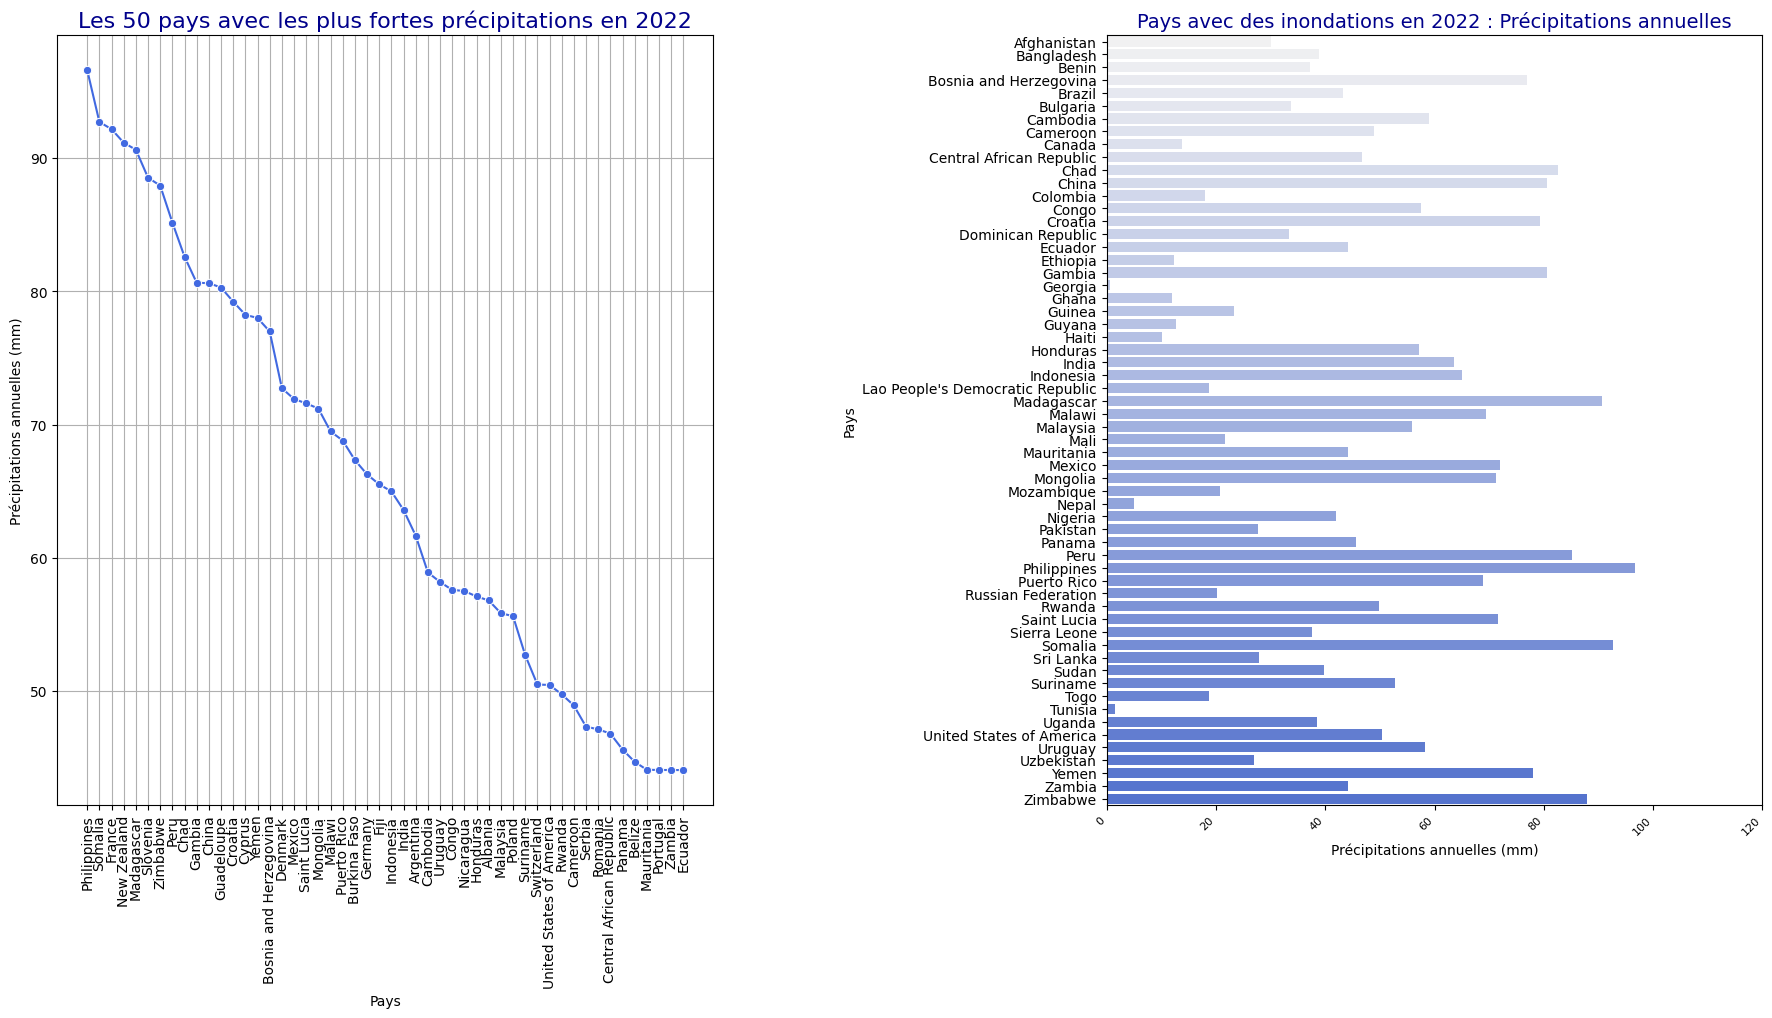

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Étape 1 : Filtrer les données pour l'année 2022
data_2016 = data[data['Year'] == 2022]

# Étape 2 : Filtrer les pays avec les plus fortes précipitations
precip_col = 'Precipitation'
country_col = 'Country'

# Vérifier que les colonnes nécessaires existent dans le dataframe
if precip_col in data_2016.columns and country_col in data_2016.columns:
    # Trier les pays par précipitations de manière décroissante
    top_precip_data = data_2016[[country_col, precip_col]].drop_duplicates().sort_values(by=precip_col, ascending=False)

    # Prendre les 50 premiers pays avec les plus fortes précipitations
    top_50_precip_data = top_precip_data.head(50)

    # Étape 3 : Filtrer pour les inondations (Flood) uniquement
    disaster_col = 'Disaster Type'  # Nom exact de la colonne pour les types de catastrophes

    if disaster_col in data_2016.columns and precip_col in data_2016.columns and country_col in data_2016.columns:
        # Filtrer les pays où la catastrophe est une inondation
        flood_data = data_2016[data_2016[disaster_col].str.contains('Flood', case=False, na=False)]

        # Conserver uniquement les pays et précipitations associés aux inondations
        flood_summary = flood_data[[country_col, precip_col, disaster_col]].drop_duplicates()

        # Créer une figure avec deux graphiques côte à côte
        fig, axes = plt.subplots(1, 2, figsize=(22, 10))  # Taille de la figure augmentée

        # Graphique 1 : Précipitations des 50 pays avec les plus fortes précipitations
        sns.lineplot(
            data=top_50_precip_data,  # Utiliser les 50 pays avec les précipitations les plus élevées
            x=country_col,  # Pays
            y=precip_col,   # Précipitations
            marker="o",  # Ajouter des marqueurs pour chaque pays
            color='royalblue',  # Couleur bleue claire pour la ligne
            ax=axes[0]  # Affecter ce graphique à la première sous-figure
        )
        axes[0].set_title("Les 50 pays avec les plus fortes précipitations en 2022", fontsize=16, color='darkblue')
        axes[0].set_xlabel("Pays")
        axes[0].set_ylabel("Précipitations annuelles (mm)")
        axes[0].tick_params(axis='x', rotation=90)  # Rotation des noms de pays pour plus de lisibilité
        axes[0].grid(True)

        # Graphique 2 : Précipitations pour les pays avec des inondations
        # Créer un dégradé de bleu clair à bleu foncé et extraire une palette de couleurs
        palette = sns.light_palette("royalblue", n_colors=len(flood_summary))

        sns.barplot(
            data=flood_summary,
            x='Precipitation',
            y=country_col,
            palette=palette,  # Utiliser la palette de couleurs générée
            ax=axes[1]  # Affecter ce graphique à la deuxième sous-figure
        )
        axes[1].set_title("Pays avec des inondations en 2022 : Précipitations annuelles", fontsize=14, color='darkblue')
        axes[1].set_xlabel("Précipitations annuelles (mm)")
        axes[1].set_ylabel("Pays")

        # Rotation et ajustement des labels de l'axe X
        plt.xticks(axes[1].get_xticks(), axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=8, fontweight='light')

        # Ajuster l'espacement entre les graphiques
        plt.subplots_adjust(wspace=0.6, hspace=0.4)  # Augmenter l'espacement horizontal à 0.6

        # Afficher la figure
        plt.show()

else:
    print("Assurez-vous que les colonnes 'Precipitation' et 'Country' existent.")

In [ ]:
import pandas as pd
import plotly.express as px

# Charger les données (Assurez-vous que le DataFrame 'data' est bien chargé avant ce bloc)
# data = pd.read_csv('base_fusion_filtered.csv')  # Si vous avez un fichier CSV

# Filtrer les données pour l'année 2017
data_2017 = data[data['Year'] == 2017]

# Filtrer les pays ayant eu des canicules ("Extreme temperature") en 2017
heatwave_data_2017 = data_2017[data_2017['Disaster Type'] == 'Extreme temperature']

# Assurez-vous que toutes les régions ont des données de température, sinon remplacez les manquantes
data_2017.loc[:, 'Temperature'] = data_2017['Temperature'].fillna(data_2017['Temperature'].mean())

# Créer la carte choroplèthe avec les températures moyennes par pays pour 2017
fig = px.choropleth(data_2017,
                    locations="Country",
                    locationmode="country names",  # Le nom du pays est utilisé ici
                    color="Temperature",
                    hover_name="Country",
                    color_continuous_scale="Spectral",  # Palette de couleurs Spectral (ou une autre palette de votre choix)
                    labels={"Temperature": "Température moyenne (°C)"},
                    title="Température annuelle par pays et zones touchées par les canicules en 2017")

# Vérifier que les données de température des pays avec des canicules sont suffisantes pour les bulles
print(heatwave_data_2017[['Country', 'Temperature']])

# Ajouter des bulles pour les pays ayant des "Extreme temperature" en 2017
fig.add_scattergeo(
    locations=heatwave_data_2017['Country'],  # Les pays ayant eu des canicules
    locationmode="country names",
    hoverinfo="location+text",
    text=heatwave_data_2017['Country'],  # Afficher le nom du pays au survol
    marker=dict(
        size=heatwave_data_2017['Temperature'].apply(lambda x: max(x * 0.5, 5)),  # La taille des bulles est ajustée (facteur 0.5 et taille minimale de 5)
        color='red',  # Couleur rouge pour les bulles
        opacity=0.8,  # Augmenter l'opacité pour rendre les bulles visibles
        line=dict(width=2, color='black')  # Contour plus épais en noir pour plus de contraste
    ),
    name="Pays touchés par des canicules"  # Nom de la légende pour les pays touchés
)

# Mettre à jour la disposition de la carte
fig.update_layout(
    title_font=dict(size=20, color="darkgreen"),  # Titre en vert foncé pastel
    legend=dict(
        title=None,  # Retirer le titre de la légende
        itemsizing='constant',
        itemwidth=30,  # Augmenter itemwidth à 30
        tracegroupgap=5,
        font=dict(size=12),  # Petite taille de police pour la légende
        orientation="h",  # Légende horizontale pour plus d'espace
        yanchor="bottom",  # Ancrage vers le bas pour éviter la superposition
        y=-0.2,  # Décalage de la légende vers le bas pour éviter la superposition avec la carte
        xanchor="center",  # Centrer la légende
        x=0.5  # Positionner la légende au centre
    ),
    # Ajouter une trace pour la petite bulle rouge dans la légende (trace invisible dans la carte, mais présente dans la légende)
    showlegend=True,
    annotations=[
        dict(
            x=0.5,
            y=-0.3,  # Placer l'annotation un peu plus bas sous l'échelle
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=12, color="black"),
            align="center",
            text="• Les bulles rouges dans la carte représentent les pays touchés par des canicules en 2017",  # Texte explicatif dans l'annotation
            bgcolor="rgba(255, 255, 255, 0.7)",
            borderpad=5
        )
    ]
)

# Personnaliser l'apparence géographique
fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="white")

# Réduire les marges et ajuster la carte pour éviter les superpositions
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":80})  # Augmenter la marge inférieure pour la légende

# Afficher la carte
fig.show()


     Country  Temperature
159  Albania     9.548151
160  Algeria    16.423052
174  Belarus    16.621552
213   Greece    12.762618
261  Morocco    21.921411
295   Serbia    14.041645
312  Ukraine    18.776425


In [ ]:
import pandas as pd
import plotly.express as px

# Charger les données (Assurez-vous que le DataFrame data est bien chargé avant ce bloc)
# data = pd.read_csv('base_fusion_filtered.csv')  # Si vous avez un fichier CSV

# Filtrer les données pour l'année 2019
data_2018 = data[data['Year'] == 2019]

# Filtrer les pays ayant eu des canicules ("Extreme temperature") en 2019
heatwave_data = data_2018[data_2018['Disaster Type'] == 'Extreme temperature']

# Assurez-vous que toutes les régions ont des données de température, sinon remplacez les manquantes
data_2018.loc[:, 'Temperature'] = data_2018['Temperature'].fillna(data_2018['Temperature'].mean())

# Créer la carte choroplèthe avec les températures moyennes par pays pour 2019
fig = px.choropleth(data_2018,
                    locations="Country",
                    locationmode="country names",  # Le nom du pays est utilisé ici
                    color="Temperature",
                    hover_name="Country",
                    color_continuous_scale="Spectral",  # Palette de couleurs Spectral (ou une autre palette de votre choix)
                    labels={"Temperature": "Température moyenne (°C)"},
                    title="Température annuelle par pays et zones touchées par les canicules en 2019")

# Vérifier que les données de température des pays avec des canicules sont suffisantes pour les bulles
print(heatwave_data[['Country', 'Temperature']])

# Ajouter des bulles pour les pays ayant des "Extreme temperature" en 2019
fig.add_scattergeo(
    locations=heatwave_data['Country'],  # Les pays ayant eu des canicules
    locationmode="country names",
    hoverinfo="location+text",
    text=heatwave_data['Country'],  # Afficher le nom du pays au survol
    marker=dict(
        size=heatwave_data['Temperature'].apply(lambda x: max(x * 0.5, 5)),  # La taille des bulles est ajustée (facteur 0.5 et taille minimale de 5)
        color='red',  # Couleur rouge pour les bulles
        opacity=0.8,  # Augmenter l'opacité pour rendre les bulles visibles
        line=dict(width=2, color='black')  # Contour plus épais en noir pour plus de contraste
    ),
    name="Pays touchés par des canicules"  # Nom de la légende pour les pays touchés
)

# Mettre à jour la disposition de la carte
fig.update_layout(
    title_font=dict(size=20, color="darkgreen"),  # Titre en vert foncé pastel
    legend=dict(
        title=None,  # Retirer le titre de la légende
        itemsizing='constant',
        itemwidth=30,  # Augmenter itemwidth à 30
        tracegroupgap=5,
        font=dict(size=12),  # Petite taille de police pour la légende
        orientation="h",  # Légende horizontale pour plus d'espace
        yanchor="bottom",  # Ancrage vers le bas pour éviter la superposition
        y=-0.2,  # Décalage de la légende vers le bas pour éviter la superposition avec la carte
        xanchor="center",  # Centrer la légende
        x=0.5  # Positionner la légende au centre
    ),
    # Ajouter une trace pour la petite bulle rouge dans la légende (trace invisible dans la carte, mais présente dans la légende)
    showlegend=True,
    annotations=[
        dict(
            x=0.5,
            y=-0.3,  # Placer l'annotation un peu plus bas sous l'échelle
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=12, color="black"),
            align="center",
            text="• Les bulles rouges dans la carte représentent les pays touchés par des canicules en 2019",  # Texte explicatif dans l'annotation
            bgcolor="rgba(255, 255, 255, 0.7)",
            borderpad=5
        )
    ]
)

# Personnaliser l'apparence géographique
fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="white")

# Réduire les marges et ajuster la carte pour éviter les superpositions
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":80})  # Augmenter la marge inférieure pour la légende

# Afficher la carte
fig.show()


        Country  Temperature
495     Algeria    19.042952
503     Austria    12.975110
508  Bangladesh    16.495225
552      France    12.770304
559     Germany    16.232561
574       Italy    15.295198
579       Japan    17.071820
598    Mongolia    14.071752
649       Spain    19.124695


In [ ]:
import pandas as pd
import plotly.express as px

# Charger les données (Assurez-vous que le DataFrame 'data' est bien chargé avant ce bloc)
# data = pd.read_csv('base_fusion_filtered.csv')  # Si vous avez un fichier CSV

# Filtrer les données pour l'année 2022
data_2022 = data[data['Year'] == 2022]

# Filtrer les pays ayant eu des canicules ("Extreme temperature") en 2022
heatwave_data_2022 = data_2022[data_2022['Disaster Type'] == 'Extreme temperature']

# Assurez-vous que toutes les régions ont des données de température, sinon remplacez les manquantes
data_2022.loc[:, 'Temperature'] = data_2022['Temperature'].fillna(data_2022['Temperature'].mean())

# Créer la carte choroplèthe avec les températures moyennes par pays pour 2022
fig = px.choropleth(data_2022,
                    locations="Country",
                    locationmode="country names",  # Le nom du pays est utilisé ici
                    color="Temperature",
                    hover_name="Country",
                    color_continuous_scale="Spectral",  # Palette de couleurs Spectral (ou une autre palette de votre choix)
                    labels={"Temperature": "Température moyenne (°C)"},
                    title="Température annuelle par pays et zones touchées par les canicules en 2022")

# Vérifier que les données de température des pays avec des canicules sont suffisantes pour les bulles
print(heatwave_data_2022[['Country', 'Temperature']])

# Ajouter des bulles pour les pays ayant des "Extreme temperature" en 2022
fig.add_scattergeo(
    locations=heatwave_data_2022['Country'],  # Les pays ayant eu des canicules
    locationmode="country names",
    hoverinfo="location+text",
    text=heatwave_data_2022['Country'],  # Afficher le nom du pays au survol
    marker=dict(
        size=heatwave_data_2022['Temperature'].apply(lambda x: max(x * 0.5, 5)),  # La taille des bulles est ajustée (facteur 0.5 et taille minimale de 5)
        color='red',  # Couleur rouge pour les bulles
        opacity=0.8,  # Augmenter l'opacité pour rendre les bulles visibles
        line=dict(width=2, color='black')  # Contour plus épais en noir pour plus de contraste
    ),
    name="Pays touchés par des canicules"  # Nom de la légende pour les pays touchés
)

# Mettre à jour la disposition de la carte
fig.update_layout(
    title_font=dict(size=20, color="darkgreen"),  # Titre en vert foncé pastel
    legend=dict(
        title=None,  # Retirer le titre de la légende
        itemsizing='constant',
        itemwidth=30,  # Augmenter itemwidth à 30
        tracegroupgap=5,
        font=dict(size=12),  # Petite taille de police pour la légende
        orientation="h",  # Légende horizontale pour plus d'espace
        yanchor="bottom",  # Ancrage vers le bas pour éviter la superposition
        y=-0.2,  # Décalage de la légende vers le bas pour éviter la superposition avec la carte
        xanchor="center",  # Centrer la légende
        x=0.5  # Positionner la légende au centre
    ),
    # Ajouter une trace pour la petite bulle rouge dans la légende (trace invisible dans la carte, mais présente dans la légende)
    showlegend=True,
    annotations=[
        dict(
            x=0.5,
            y=-0.3,  # Placer l'annotation un peu plus bas sous l'échelle
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=12, color="black"),
            align="center",
            text="• Les bulles rouges dans la carte représentent les pays touchés par des canicules en 2022",  # Texte explicatif dans l'annotation
            bgcolor="rgba(255, 255, 255, 0.7)",
            borderpad=5
        )
    ]
)

# Personnaliser l'apparence géographique
fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="white")

# Réduire les marges et ajuster la carte pour éviter les superpositions
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":80})  # Augmenter la marge inférieure pour la légende

# Afficher la carte
fig.show()


          Country  Temperature
1058      Albania    15.623566
1061      Austria    10.804290
1065      Belgium    11.989037
1074     Bulgaria    14.729992
1105      Croatia     7.973967
1106       Cyprus    18.142768
1107      Denmark    14.131919
1117      Estonia    14.045847
1121      Finland    15.155529
1123       France    19.793109
1128      Germany    17.831940
1132       Greece    14.175473
1143        India    14.480525
1152      Ireland    13.498855
1155       Latvia    20.004773
1156    Lithuania    13.340819
1174     Mongolia    12.119208
1175   Montenegro    11.311126
1187       Norway    19.424011
1192     Pakistan    19.054565
1207       Poland     2.923464
1211     Portugal    12.106222
1214      Romania    13.438188
1220       Serbia    10.253487
1222     Slovenia    10.954543
1225        Spain    21.233088
1233       Sweden    15.091322
1234  Switzerland    16.367122


In [ ]:
import pandas as pd

# Liste des pays à filtrer (combinaison des deux listes)
countries = ['Morocco', 'Algeria', 'Greece', 'Albania', 'Belarus', 'Ukraine', 'Serbia',
             'France', 'Spain', 'Bangladesh', 'Mongolia', 'Japan', 'Canada', 'United States',
             'Italy', 'Austria', 'Ireland', 'Portugal', 'Belgium', 'Germany', 'Denmark', 'Norway',
             'Croatia', 'Pakistan', 'Romania', 'India','Finland','Bulgaria']

# Charger les données
data = pd.read_csv('base_fusion_filtered.csv')

# Filtrer les données pour les pays et les années spécifiques (2017, 2019, 2022)
filtered_data = data[(data['Country'].isin(countries)) & (data['Year'].isin([2017, 2019, 2022]))]

# Créer un tableau pivot pour afficher les températures par pays et par année
pivot_table = filtered_data.pivot_table(values='Temperature',
                                       index='Country',
                                       columns='Year',
                                       aggfunc='mean')

# Trier le tableau par ordre croissant des pays
pivot_table = pivot_table.sort_index()

# Afficher le tableau
print(pivot_table)

# Optionnel : Vous pouvez enregistrer ce tableau dans un fichier CSV si nécessaire
pivot_table.to_csv('temperature_by_country_year_sorted_2017_2019_2022.csv')

Year             2017       2019       2022
Country                                    
Albania      9.548151  17.910102  15.623566
Algeria     16.423052  19.042952  15.292410
Austria     17.863144  12.975110  10.804290
Bangladesh  12.407174  16.495225  18.558551
Belarus     16.621552        NaN        NaN
Belgium           NaN        NaN  11.989037
Bulgaria          NaN        NaN  14.729992
Canada      14.097350  15.698235  15.789479
Croatia     13.316494   9.056311   7.973967
Denmark           NaN        NaN  14.131919
Finland           NaN        NaN  15.155529
France      11.616988  12.770304  19.793109
Germany           NaN  16.232561  17.831940
Greece      12.762618        NaN  14.175473
India             NaN        NaN  14.480525
Ireland     12.841194        NaN  13.498855
Italy       16.655307  15.295198        NaN
Japan       12.057544  17.071820        NaN
Mongolia    12.914714  14.071752  12.119208
Morocco     21.921411        NaN        NaN
Norway            NaN        NaN